In [1]:
import pandas as pd
import numpy as np
import json
import re
from llms import gemini
from llms import chatGPT
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px
from sklearn.manifold import TSNE
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader
import plotly.io as pio
import os
from os import getenv
from dotenv import load_dotenv
import requests
import ast



In [10]:
locations = pd.read_csv("../output/EDA_data/automation_by_geography.csv",index_col=0)
locations.Boundary = locations.Boundary.apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else x)

In [16]:
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import branca.colormap as cm

# Initialize the map centered around the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4, tiles='CartoDB positron')

# Normalize the onet_rating for color mapping
vmin = 0
vmax = 200
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap_metro = cm.LinearColormap(
    colors=['lightblue', 'cyan', 'lightgreen', 'green', 'darkgreen'],
    vmin=vmin,  # Minimum rating
    vmax=vmax  # Maximum rating
)

cmap_rural = cm.LinearColormap(
    colors=['yellow', '#FFD700', '#FFA500', 'red', 'darkred'],
    vmin=vmin,  # Minimum rating
    vmax=vmax  # Maximum rating
)

# Function to convert the bounds to a list of lat/lng
def get_boundary_coords(boundary):
    ne = boundary['bounds']['northeast']
    sw = boundary['bounds']['southwest']
    return [
        [ne['lat'], ne['lng']],
        [ne['lat'], sw['lng']],
        [sw['lat'], sw['lng']],
        [sw['lat'], ne['lng']],
        [ne['lat'], ne['lng']]
    ]

# Add polygons to the map
for idx, row in list(locations.dropna(subset=["Boundary"]).iterrows()):
    try:
        boundary_coords = get_boundary_coords(row['Boundary'])
    except KeyError:
        continue
    
    # Choose color map based on type
    if row['Type'] == 'METRO':
        color = cmap_metro(row['weighted_automation_#_per_1000_people'])
    else:
        color = cmap_rural(row['weighted_automation_#_per_1000_people'])
    
    folium.Polygon(
        locations=boundary_coords,
        color=None,
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=row['name']
    ).add_to(m)

# Add color bar legend for metro
cmap_metro.caption = 'Metro Areas: Weighted # of jobs Automated Per 10K employees Scale'
cmap_metro.add_to(m)

# Add color bar legend for rural
cmap_rural.caption = 'Rural Areas: Weighted # of jobs Automated Per 10K employees Scale'
cmap_rural.add_to(m)

# Save and display the map
m.save('map.html')
m


In [17]:
df = pd.read_csv("../output/EDA_data/startup_data.csv")
df["weighted_JOBS_1000_diff"] = (df["weighted_JOBS_1000_METRO"]-df["weighted_JOBS_1000_RURAL"])/df["weighted_JOBS_1000_METRO"]*100

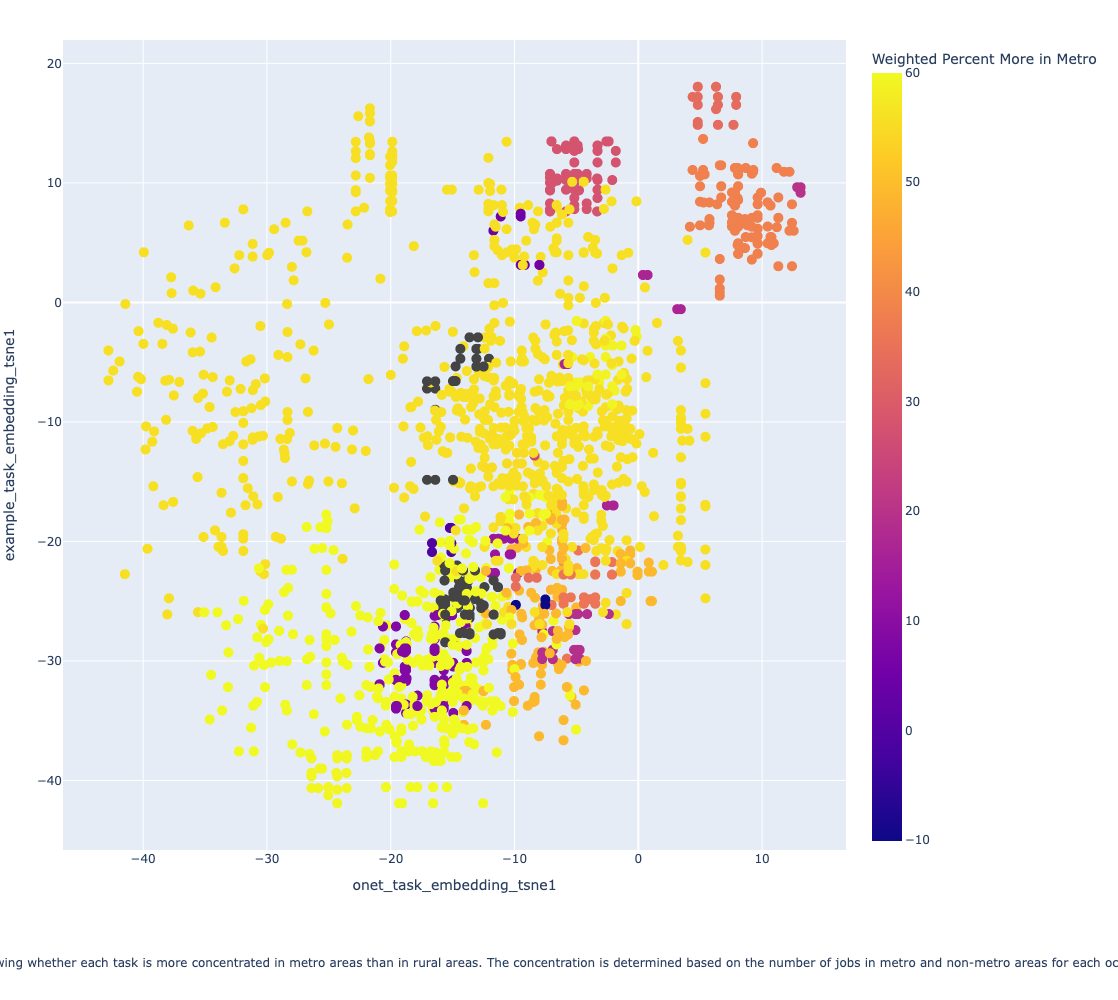

In [42]:


occ_type = "Major Group Name"
occ_groups = list(df.groupby(occ_type)["onet_title"].count().sort_values(ascending=False).index)

values = ["weighted_JOBS_1000_diff"]

for occ_group in occ_groups[:1]:
    for value in values:
        graph_df = df[df[occ_type] == occ_group]
        graph_df.head()
        
        # Plot using Plotly with clusters
        fig = px.scatter(graph_df, x='onet_task_embedding_tsne1', y='example_task_embedding_tsne1',
                         color=value,
                         hover_data=['onet_task','job'],
                         labels={value: 'Weighted Percent More in Metro'},
                         range_color=(-10, 60)
                         )
        fig.update_traces(marker_size=10)
        fig.update_layout(
            title=f"", 
            hovermode='closest',
            width=1000,  # Set the width of the figure
            height=1000,  # Set the height of the figure
            legend=dict(font=dict(size=5)),
            margin=dict(l=40, r=40, t=40, b=150)
        )
        
        caption = (
            f"""Scatter plot of task embeddings for {occ_group}, showing whether each task is more concentrated in metro areas than in rural areas. 
            The concentration is determined based on the number of jobs in metro and non-metro areas for each occupation, weighted by total employment in each area."""
        )

        fig.add_annotation(
            text=caption,
            xref="paper", yref="paper",
            x=0.5, y=-0.15,
            showarrow=False,
            font=dict(size=12),
        )
        
        fig.show()


In [63]:
all_tasks = pd.read_csv("../output/EDA_data/all_tasks_automation_activity.csv",index_col=0)
skills_activities = pd.read_csv("../output/parsed_BLS_data/activity_skill_embeddings.csv")
all_tasks = all_tasks.merge(skills_activities,on=["activity"], how="left")
grouped = all_tasks.groupby(["activity","skill"]).aggregate({"task_automation_rating":"sum","activity_embedding_tsne1":"first","skill_embedding_tsne1":"first"}).reset_index()
grouped['text_label'] = grouped.apply(lambda row: row['skill'] if row['task_automation_rating'] >= 0 else '', axis=1)


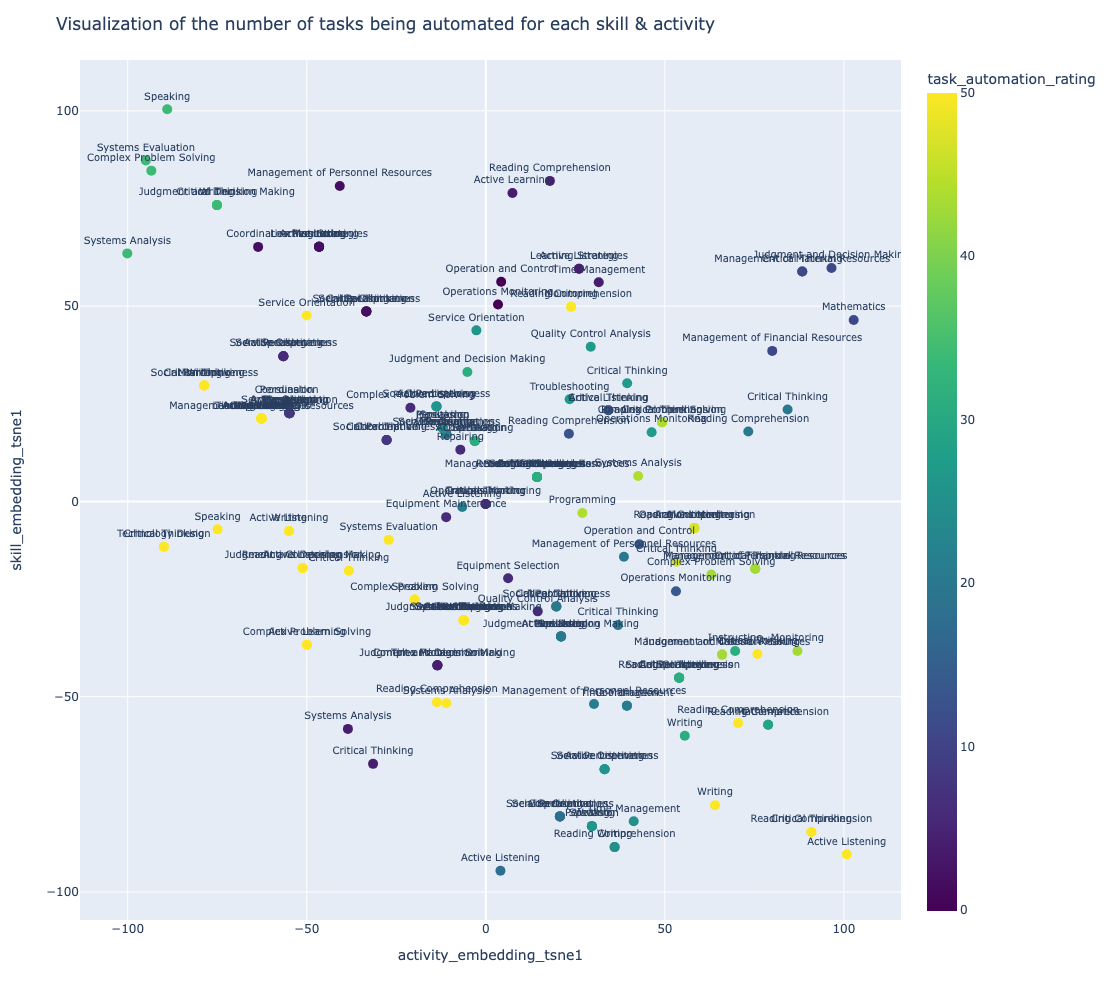

In [65]:

# Assuming `grouped` is your DataFrame
fig = px.scatter(grouped, 
                 x='activity_embedding_tsne1', 
                 y='skill_embedding_tsne1',
                 color="task_automation_rating",
                 color_continuous_scale=px.colors.sequential.Viridis,
                 hover_data=['activity', 'skill'],
                 text='text_label',  # Add the filtered text labels
                 labels={'value': 'Value'},
                 range_color=(0, 50))

fig.update_traces(marker_size=10, textfont=dict(size=10), textposition='top center')                  

fig.update_layout(
    title=f"Visualization of the number of tasks being automated for each skill & activity", 
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=1000,  # Set the height of the figure
    legend=dict(font=dict(size=8)),
)

fig.show()
# pio.write_html(fig, file='Skills Automated.html', auto_open=True)

In [68]:
all_occupations = pd.read_csv("../output/EDA_data/all_occupations_automation.csv")
bins = [0, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]
labels = ['<30k', '30k-35k', '35k-40k', '40k-45k', '45k-50k', '50k-55k', '55k-60k', '60k-65k', '65k-70k', '70k-75k', '75k-80k', '80k-85k', '85k-90k', '90k-95k', '95k-100k']
bins = [0,30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
labels = ['<30k', '30k-40k', '40k-50k', '50k-60k', '60k-70k', '70k-80k', '80k-90k', '90k-100k']


# Create a new column 'H_MEDIAN_US_Bucket' with the bucket labels
all_occupations['A_MEDIAN_US_Bucket'] = pd.cut(all_occupations['A_MEDIAN_US'], bins=bins, labels=labels, right=False)

# Group by 'H_MEDIAN_US_Bucket' and 'Detailed_Occupation'
grouped = all_occupations.groupby(['A_MEDIAN_US_Bucket','Minor Group Name']).agg({
    'occupation_onet_rating': 'sum',
    'Detailed Occupation': 'count'
}).rename(columns={'Detailed Occupation': 'count'})

# # Calculate the percentage likelihood to be automated
grouped['percent_likely_automated'] = grouped['occupation_onet_rating'] / grouped['count']

# Reset index to make the DataFrame easier to read
grouped = grouped.reset_index().dropna()


KeyError: 'Minor Group Name'

In [69]:
all_occupations

Unnamed: 0                                               Task  \
0               0  Accompany buyers during visits to and inspecti...   
1               1  Advise clients on market conditions, prices, m...   
2               2  Advise sellers on how to make homes more appea...   
3               3  Answer clients' questions regarding constructi...   
4               4      Appraise properties to determine loan values.   
...           ...                                                ...   
18767       18767  Unload cars containing liquids by connecting h...   
18768       18768  Clean interiors of tank cars or tank trucks, u...   
18769       18769  Lower gauge rods into tanks or read meters to ...   
18770       18770  Operate conveyors and equipment to transfer gr...   
18771       18771  Perform general warehouse activities, such as ...   

       onet_weight Detailed Occupation                         onet_title  \
0         0.833333             41-9022           Real Estate Sales Agents   
1         0.333333             41-9022           Real Estate Sales Agents   
2         1.833333             41-9022           Real Estate Sales Agents   
3         0.333333             41-9022           Real Estate Sales Agents   
4         0.666667             41-9022           Real Estate Sales Agents   
...            ...                 ...                                ...   
18767     0.000000             53-7121  Tank Car, Truck, and Ship Loaders   
18768     0.000000             53-7121  Tank Car, Truck, and Ship Loaders   
18769     0.000000             53-7121  Tank Car, Truck, and Ship Loaders   
18770     0.000000             53-7121  Tank Car, Truck, and Ship Loaders   
18771     0.000000             53-7121  Tank Car, Truck, and Ship Loaders   

       Percent of 10K workers  task_automation_rating  H_MEDIAN_US  \
0                    0.001305                     1.0         24.0   
1                    0.001305                     1.0         24.0   
2                    0.001305                     1.0         24.0   
3                    0.001305                     1.0         24.0   
4                    0.001305                     1.0         24.0   
...                       ...                     ...          ...   
18767                0.000084                     0.0         26.0   
18768                0.000084                     0.0         26.0   
18769                0.000084                     0.0         26.0   
18770                0.000084                     0.0         26.0   
18771                0.000084                     0.0         26.0   

       A_MEDIAN_US  TOT_EMP_US A_MEDIAN_US_Bucket  
0          49980.0    193010.0            40k-50k  
1          49980.0    193010.0            40k-50k  
2          49980.0    193010.0            40k-50k  
3          49980.0    193010.0            40k-50k  
4          49980.0    193010.0            40k-50k  
...            ...         ...                ...  
18767      53930.0     12470.0            50k-60k  
18768      53930.0     12470.0            50k-60k  
18769      53930.0     12470.0            50k-60k  
18770      53930.0     12470.0            50k-60k  
18771      53930.0     12470.0            50k-60k  

[18772 rows x 11 columns]